In [5]:
# run this first
#!py -m pip install -q timm   # for EfficientNet variants (optional)
import os, glob, zipfile, shutil, json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import timm
from sklearn.metrics import confusion_matrix, classification_report
print("PyTorch version:", torch.__version__)


PyTorch version: 2.5.1


In [6]:
import torch

print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))


torch version: 2.5.1
cuda available: True
device count: 1
device name: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [7]:
from pathlib import Path
import os

# This is the folder shown next to your notebook in Jupyter
dataset_dir = Path("Medicinal Leaf dataset")

print("Dataset path:", dataset_dir.resolve())
print("Exists:", dataset_dir.exists())

# Optional: quick tree view
for root, dirs, files in os.walk(dataset_dir):
    level = root.replace(str(dataset_dir), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/ - {len(files)} files")
    for f in files[:5]:
        print(f"{indent}    {f}")
    if level >= 2:   # stop after depth 2
        break


Dataset path: C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset
Exists: True
Medicinal Leaf dataset/ - 0 files
    Aloevera/ - 118 files
        10.jpg
        100.jpg
        102.jpg
        104.jpg
        106.jpg
    Amla/ - 67 files
        350.jpg
        352.jpg
        354.jpg
        356.jpg
        358.jpg
    Amruthaballi/ - 91 files
        484.jpg
        486.jpg
        488.jpg
        490.jpg
        492.jpg
    Arali/ - 89 files
        666.jpg
        668.jpg
        670.jpg
        672.jpg
        674.jpg
    ashoka/ - 81 files
        1000.jpg
        1002.jpg
        1004.jpg
        844.jpg
        846.jpg
    Astma_weed/ - 82 files
        1006.jpg
        1008.jpg
        1010.jpg
        1012.jpg
        1014.jpg
    Badipala/ - 76 files
        1170.jpg
        1172.jpg
        1174.jpg
        1176.jpg
        1178.jpg
    Balloon_Vine/ - 61 files
        1322.jpg
        1324.

In [9]:
# Adjust image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load datasets if structure is dataset_dir/class_name/*.jpg
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_tfms)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split
val_pct = 0.2
val_len = int(len(full_dataset) * val_pct)
train_len = len(full_dataset) - val_len
train_ds, val_ds = random_split(full_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))
# replace val transform for val_ds
val_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Using device: cuda
Classes: ['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']
Train samples: 5520 Val s

In [10]:
# Use EfficientNet (via timm) or ResNet50 fallback
model_name = 'tf_efficientnet_b0_ns'  # good baseline; change if you like
try:
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    print("Loaded", model_name)
except Exception as e:
    print("timm failed, falling back to resnet50:", e)
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


C:\Users\ASUS\miniconda3\envs\medic-ml\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Loaded tf_efficientnet_b0_ns


In [11]:
import torch

print("cuda.is_available():", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())
print("torch.version.cuda:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


cuda.is_available(): True
device_count: 1
torch.version.cuda: 12.1
GPU name: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [12]:
from tqdm import tqdm  # ← add at top

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    # Wrap loader with tqdm for progress bar
    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return running_loss/total, correct/total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss=0
    correct=0
    total=0
    preds_all=[]
    labels_all=[]

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy().tolist())
            labels_all.extend(labels.cpu().numpy().tolist())
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    return running_loss/total, correct/total, np.array(labels_all), np.array(preds_all)


EPOCHS = 8
best_val_acc = 0.0
print("start")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
print("Best val acc:", best_val_acc)

print(f"🔥 Epoch {epoch+1}/{EPOCHS} | "
      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


start


Epoch 1/8: train_loss=3.6994, train_acc=0.2120, val_loss=2.6193, val_acc=0.4906


Epoch 2/8: train_loss=1.6989, train_acc=0.7014, val_loss=1.0612, val_acc=0.7739


Epoch 3/8: train_loss=0.6438, train_acc=0.8975, val_loss=0.5633, val_acc=0.8833


Epoch 4/8: train_loss=0.2754, train_acc=0.9683, val_loss=0.3659, val_acc=0.9246


Epoch 5/8: train_loss=0.1377, train_acc=0.9866, val_loss=0.2824, val_acc=0.9355


Epoch 6/8: train_loss=0.0788, train_acc=0.9949, val_loss=0.2707, val_acc=0.9355


Epoch 7/8: train_loss=0.0592, train_acc=0.9976, val_loss=0.2461, val_acc=0.9362


Epoch 8/8: train_loss=0.0478, train_acc=0.9987, val_loss=0.2331, val_acc=0.9435
Best val acc: 0.9434782608695652
🔥 Epoch 8/8 | Train Loss: 0.0478 | Train Acc: 0.9987 | Val Loss: 0.2331 | Val Acc: 0.9435


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5388\2580188492.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Loaded best_model.pth


Val accuracy: 0.9434782608695652
                         precision    recall  f1-score   support

               Aloevera       0.92      0.88      0.90        25
                   Amla       0.88      0.93      0.90        15
           Amruthaballi       0.86      0.92      0.89        13
                  Arali       1.00      1.00      1.00        19
             Astma_weed       0.80      0.92      0.86        13
               Badipala       0.91      0.91      0.91        11
           Balloon_Vine       1.00      0.88      0.93        16
                 Bamboo       0.96      0.96      0.96        24
                  Beans       0.96      1.00      0.98        23
                  Betel       1.00      0.96      0.98        25
                 Bhrami       0.86      1.00      0.92        18
             Bringaraja       0.89      0.94      0.92        18
             Caricature       1.00      0.85      0.92        13
                 Castor       0.96      0.96      0.96  

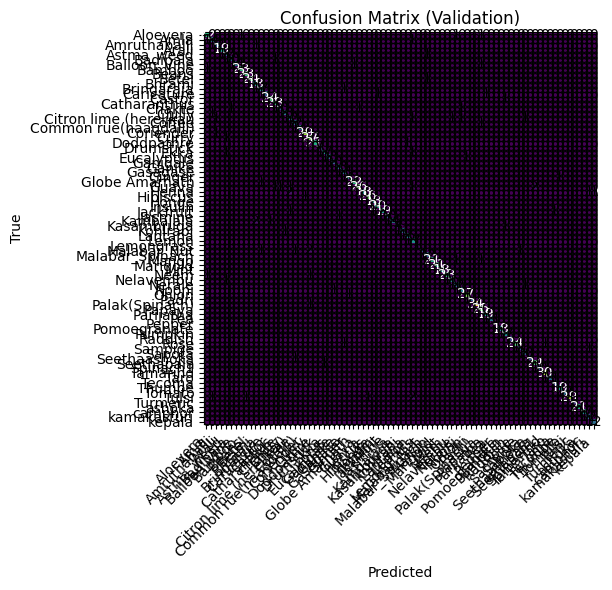

In [13]:
# Load best model weights if saved
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
    print("Loaded best_model.pth")

val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
print("Val accuracy:", val_acc)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_xticks(np.arange(len(class_names))); ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title('Confusion Matrix (Validation)')
plt.tight_layout()
os.makedirs('report_figs', exist_ok=True)
plt.savefig('report_figs/fig1_confusion_matrix.png', dpi=200)
plt.show()

In [16]:
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm